In [19]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pathlib import Path
import sys

root = str(Path().resolve().parent)
if root not in sys.path:
    sys.path.append(root)
print(*sys.path, sep="\n")

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/rfdsp_sim/python/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/rfdsp_sim/python


In [52]:
from importlib import reload
from rfdsppy import calc, ofdm, rf_tx_analog, rf_tx_fw

reload(calc)
reload(ofdm)
reload(rf_tx_analog)
reload(rf_tx_fw)

<module 'rfdsppy.rf_tx_fw' from '/home/ryanwtsai/repos/rfdsp_sim/python/rfdsppy/rf_tx_fw.py'>

In [3]:
def get_pa_params(target_comp):
    # Return PA params to target various compression points
    # PA gain = 30dB, PA output power = 27dBm
    
    pa_gain = 30 # dB
    pa_gain_lin = 10**(pa_gain/20)
    
    pa_params = {'g':pa_gain_lin}
    pa_params['smoothness'] = 2
    pa_params['a'] = 1
    pa_params['b'] = 30
    
    if target_comp == 1:
        pa_params['osat'] = 13
    elif target_comp == 2:
        pa_params['osat'] = 10
    elif target_comp == 3:
        pa_params['osat'] = 8.5
    else:
        pa_params['osat'] = target_comp
        
    return pa_params

In [57]:
modorder = 4
clipped_papr = 4.5; mpr = 1
unclipped_papr = 6.5
p_avg = 27 # dBm @ PA output (RF power) for MPR0
p_avg = p_avg-mpr
p_peak = p_avg+(clipped_papr+3)
p_avg = p_peak-(unclipped_papr+3)
# v_rms = calc.dbm2v(p_avg, 'dBm')
v_rms = calc.dbm2v(p_avg+3, 'dBm')
pa_gain = 30 # dB
pa_gain_lin = 10**(pa_gain/20)
v_rms_in = v_rms/pa_gain_lin
target_comp = 3

bw = 20
scs = 15
num_sc = 1200
start_sc = 600-round(num_sc/2)
en_tprecode = True
osr = 4
ofdm_wavgen = ofdm.OFDMWavGen(bw, scs, modorder, start_sc, num_sc=num_sc, en_tprecode=en_tprecode, osr=osr)

EVM: 3.07%


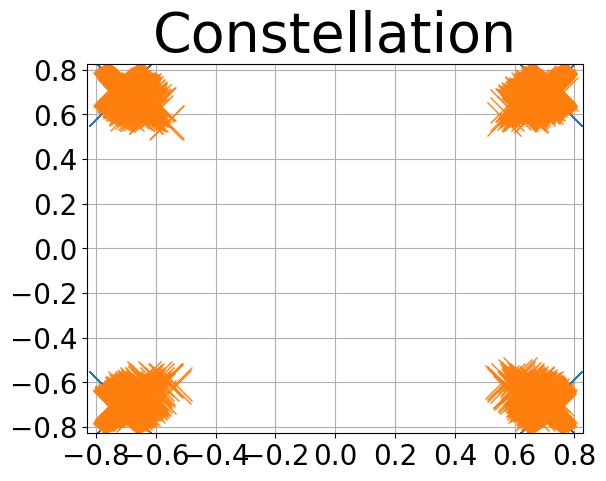

In [61]:
pa_params = get_pa_params(target_comp)

pa = rf_tx_analog.RappSaleh(cfg=pa_params)

x, x_standard = ofdm_wavgen.generate(nsym=14, seed=0)
x = x/calc.rms(x)*v_rms_in
cfg = ofdm_wavgen.get_demod_params()

y = pa.transform(x)

evm = ofdm_wavgen.calculate_evm(x_standard, y[round(cfg["wola_len"]/2):], en_plot=True)
print(f"EVM: {evm.round(2)}%")

(np.float64(3.2267246572826798), -72.36323265405846)

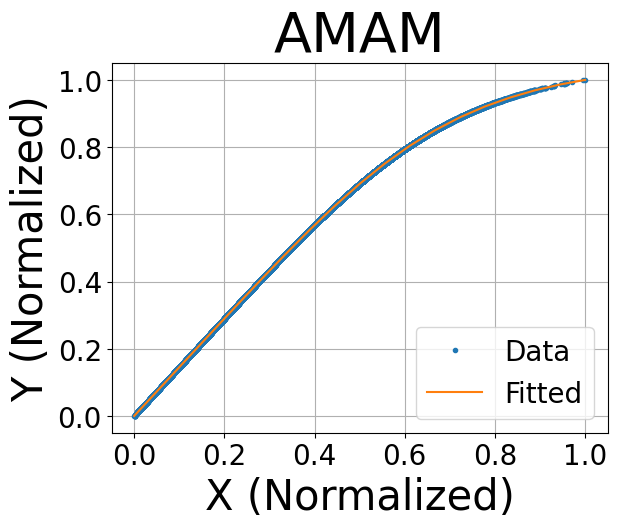

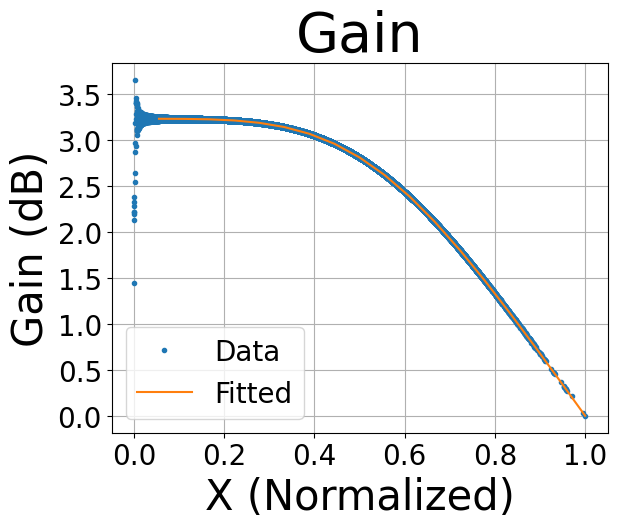

In [62]:
calc.comp_db(x, y, cfg={"en_plot": True})

In [27]:
(x.reshape(x.size, 1, copy=True)**2).squeeze()

array([ 0.00000000e+00+0.00000000e+00j,  4.40772350e-10+1.70283159e-09j,
        1.43308406e-09+1.38666153e-08j, ...,
       -2.64212765e-08-1.01010633e-07j, -1.39626024e-09-5.73322021e-09j,
        0.00000000e+00+0.00000000e+00j], shape=(122792,))

np.float64(0.0842294834605204)

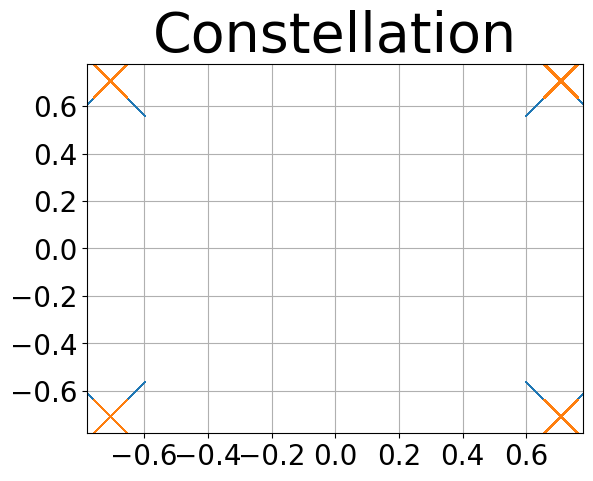

In [10]:
x, x_standard = ofdm_wavgen.generate(nsym=14, seed=0)
cfg = ofdm_wavgen.get_demod_params()
ofdm_wavgen.calculate_evm(x_standard, x[round(cfg["wola_len"]/2):], en_plot=True)

In [ ]:

    
    # Generate waveform
    nsym = 14; bw = 20; scs = 15; num_sc = 1200; start_sc = 600-round(num_sc/2)
    ncp = 7; wola = 1; osr = 4; seed = 1;
    [x,x_standard,cfg_evm] = ofdm.ofdm_wavgen(nsym,bw,scs,num_sc,start_sc,modorder,en_tprecode,ncp=ncp,wola=wola,osr=osr,seed=seed)
    wola_len = cfg_evm['wola_len']
    fs = cfg_evm['fs']
    
    x = x/calc.rms(x)*v_rms_in

    # PA model
    cfg = get_pa_params(target_comp)
    cfg['en_plot'] = 1
    y = pa_model.rapp_saleh_model(cfg,x)
    #y = pa_model.pa_model(x)
    #x = x/max(abs(x))
    #y = pa_model.pa_model(x)
    
    # Plot input and output PSDs
    rbw = scs/1000
    [px,f] = calc.calculate_psd(x,fs,rbw)
    [py,_] = calc.calculate_psd(y,fs,rbw)
    px = calc.scale_psd(px,f,bw,scs,start_sc,num_sc)
    py = calc.scale_psd(py,f,bw,scs,start_sc,num_sc)
    fig = plt.figure()
    plt.plot(f,10*np.log10(px),linewidth=2.5,label='PA Input')
    plt.plot(f,10*np.log10(py),label='PA Output')
    plt.title('PSD',{'fontsize':40})
    plt.xlabel("Frequency (MHz)",{'fontsize':30})
    plt.ylabel("PSD (dBm)",{'fontsize':30})
    plt.legend(loc="lower center",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid()
    
    # Calculate power
    p_pa = calc.calculate_power(y)
    print('RF power @ PA output (dBm): ' + str(p_pa))
    
    # Calculate peak compression
    [comp,nlse] = calc.calculate_compression(x,y,cfg={'en_plot':1})
    print('Compression (dB): ' + str(comp))
    print('Forward model NLSE (dB): ' + str(nlse))
    
    # Calculate EVM
    cfg_evm['en_plot'] = 1
    evm = ofdm.ofdm_evm_calculator(cfg_evm,x_standard,y[round(wola_len/2):])
    snr = round(-20*np.log10(evm/100),2)
    print('EVM (%): ' + str(evm))
    print('SNR (dB): ' + str(snr))
    
    # Calculate ACLR
    [aclrm,aclrp] = calc.calculate_aclr(y,fs,bw,scs,en_plot=1)
    print('ACLR- (dB): ' + str(aclrm))
    print('ACLR+ (dB): ' + str(aclrp))